# effect of epistasis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


In [2]:
predicted_dataset = pd.read_csv('../data/fitness_data.csv')
# Ensure 'geno' column is of type string
predicted_dataset['geno'] = predicted_dataset['geno'].astype(str)
# Pad 'geno' strings with leading zeros to get 15-digit binary
predicted_dataset['binary'] = predicted_dataset['geno'].apply(lambda x: x.zfill(15))
#geni to a list of integers
predicted_dataset['binary'] = predicted_dataset['binary'].apply(lambda x: [int(i) for i in x])


In [3]:
predicted_dataset.columns


Index(['new_fitness', 'mutations_x', 'geno', 'log10Kd_a', 'log10Kd_i',
       'log10Kd_e', 'log10Kd_g', 'log10Kd_c', 'genotype', 'delta',
       'mutations_y', 'delta_3D', 'average_date', 'log10Kd_ACE2',
       'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309',
       's', 'predicted_s', 'binary', 'real_f', 'ln_Kd_ACE2', 'ln_Kd_CB6',
       'ln_Kd_CoV555', 'ln_Kd_REGN10987', 'ln_Kd_S309', 'pred_f', 'encoding',
       'median', 'average', 'q10', 'q25', 'q01', 'count'],
      dtype='object')

In [24]:
predicted_dataset.columns
#remove columns log10Kd_a log10Kd_i log10Kd_e log10Kd_elog10Kd_e predicted_s
predicted_dataset = predicted_dataset.drop(columns=['log10Kd_a', 'log10Kd_i', 'log10Kd_e', 'log10Kd_g','log10Kd_c', 'predicted_s'])
predicted_dataset.to_csv('../data/predicted_dataset.csv', index=False)

In [5]:
predicted_dataset['real_f']=predicted_dataset['s']+1
T=1.6
def logistic_model(x, a, C, K_1, K_2, K_3, K_4):
    return a * (1+C * np.exp(x[0]/T)) / (C * np.exp(x[0]/T) + K_1 * np.exp(x[1]/T) + K_2 * np.exp(x[2]/T) + K_3 * np.exp(x[3]/T) + K_4 * np.exp(x[4]/T) + 1)
parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])
initial_guess = [1,  1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
features = ['log10Kd_ACE2', 'log10Kd_CB6',
            'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']

for feature in features:
    # Create new column name by removing 'log10' and appending 'ln'
    new_column_name = 'ln_' + feature[5:]

    # Calculate natural logarithm by multiplying log to base 10 value by ln(10)
    predicted_dataset[new_column_name] = predicted_dataset[feature] * np.log(10)

# Print the newly created 'ln' columns
ln_features = ['ln_Kd_ACE2', 'ln_Kd_CB6',
               'ln_Kd_CoV555', 'ln_Kd_REGN10987', 'ln_Kd_S309']


predicted_dataset_existing=predicted_dataset[predicted_dataset['count']>0]
mu='S:T478K'
df_without = predicted_dataset[~predicted_dataset['mutations_x'].apply(lambda x: mu in x)]
#keep only points with 'S:T478K' in mutations_x
df_with = predicted_dataset[predicted_dataset['mutations_x'].apply(lambda x: mu in x)]
df_without_existing = predicted_dataset_existing[~predicted_dataset_existing['mutations_x'].apply(lambda x: mu in x)]
df_with_existing = predicted_dataset_existing[predicted_dataset_existing['mutations_x'].apply(lambda x: mu in x)]

#print all len
print('len of df_without:',len(df_without))
print('len of df_with:',len(df_with))
print('len of df_without_existing:',len(df_without_existing))
print('len of df_with_existing:',len(df_with_existing))

len of df_without: 16384
len of df_with: 16384
len of df_without_existing: 363
len of df_with_existing: 758


In [6]:
# Assuming your data is in a DataFrame called 'data'
X_train_without = df_without_existing[ln_features].values
X_test_without = df_without[ln_features].values
y_train_without = df_without_existing['real_f'].values

# Create and train the logistic
parameters, _ = curve_fit(logistic_model, X_train_without.T, y_train_without, p0=initial_guess,
                            bounds=parameter_bounds, method='trf', maxfev=1000000)
# Extract the fitted parameters
a, C, K_1, K_2, K_3, K_4 = parameters
y_pred_without = logistic_model(X_test_without.T, a, C, K_1, K_2, K_3, K_4)
df_without['pred_f']=y_pred_without

X_train_with = df_with_existing[ln_features].values
X_test_with = df_with[ln_features].values
y_train_with = df_with_existing['real_f'].values

# Create and train the logistic
parameters, _ = curve_fit(logistic_model, X_train_with.T, y_train_with, p0=initial_guess,
                            bounds=parameter_bounds, method='trf', maxfev=1000000)
# Extract the fitted parameters
a, C, K_1, K_2, K_3, K_4 = parameters
y_pred_with = logistic_model(X_test_with.T, a, C, K_1, K_2, K_3, K_4)
df_with['pred_f']=y_pred_with

#concatenate df_with and df_without in predicted_dataset
predicted_dataset=pd.concat([df_with,df_without])



/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_94691/2673621569.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without['pred_f']=y_pred_without
/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_94691/2673621569.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with['pred_f']=y_pred_with


In [7]:
mutation_names = ['G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N',
                  'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H']

# Predicted vs science

/var/folders/4s/fnn1b0255fb95977rmg73gx40000gn/T/ipykernel_94691/3634255422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_dataset['n_mutations'][0]=0
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


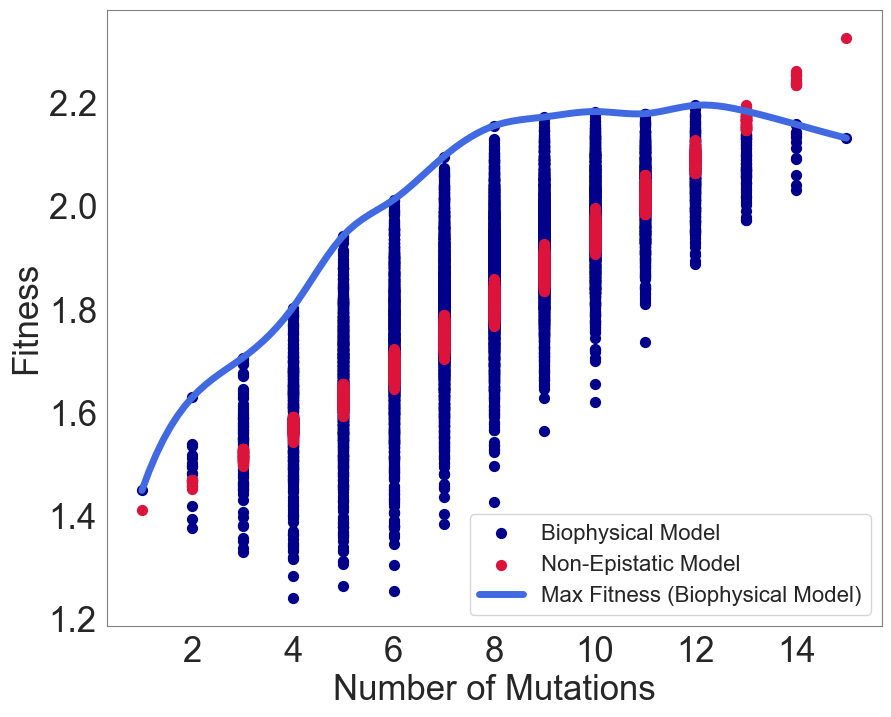

In [8]:
predicted_dataset['n_mutations'] = predicted_dataset['mutations_x'].apply(lambda x: len(x.split(',')))
#set n mutations=0 for first line
predicted_dataset['n_mutations'][0]=0
mut='S:T478K'
df_without = predicted_dataset[~predicted_dataset['mutations_x'].apply(lambda x: mut in x)]
#keep only points with 'S:T478K' in mutations_x
df_with = predicted_dataset[predicted_dataset['mutations_x'].apply(lambda x: mut in x)]
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))
# Plot the scatter plots with different colors
df_with.plot.scatter(x='n_mutations', y='pred_f', c='DarkBlue', alpha=1, label='Biophysical Model', ax=ax, s=50)
df_with.plot.scatter(x='n_mutations', y='real_f', c='Crimson', alpha=1, label='Non-Epistatic Model', ax=ax, s=50)

max_with = df_with.groupby('n_mutations')['pred_f'].max()
max_without = df_without.groupby('n_mutations')['pred_f'].max()
x_with = max_with.index
y_with = max_with.values
spline_with = interp1d(x_with, y_with, kind='cubic')

max_real_with = df_with.groupby('n_mutations')['real_f'].max()
x_real_with = max_real_with.index
y_real_with = max_real_with.values
spline_real_with = interp1d(x_real_with, y_real_with, kind='cubic')

# Create a smoother curve for plotting
x_smooth_with = np.linspace(x_with.min(), x_with.max(), 100)
# Plot the curved lines connecting the quantile values
plt.plot(x_smooth_with, spline_with(x_smooth_with), color='RoyalBlue', linestyle='-', linewidth=5, label='Max Fitness (Biophysical Model)')
# plt.plot(x_smooth_real_with, spline_real_with(x_smooth_real_with), color='FireBrick', linestyle='-', linewidth=5, label='Max Fitness (Non-Epistatic Model)')


# Create a smoother curve for plotting

# x_smooth_without = np.linspace(x_without.min(), x_without.max(), 100)


# Plot the curved lines connecting the quantile values
#plt.plot(x_smooth_without, spline_without(x_smooth_without), color='RoyalBlue', linestyle='-', label='Max Fitness (no T478K)')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# Set labels and title
plt.xlabel('Number of Mutations', fontsize=25)
plt.ylabel('Fitness', fontsize=25)
#plt.title('Fitness Prediction Comparison for Models', fontsize=20)

# Set legend
plt.legend(fontsize=16)

# Remove grid
ax.grid(False)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray') 
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')

# Save the figure (optional)
plt.savefig('log_F_vs_mu.png', dpi=300)
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'log_F_vs_mu.eps'

fig.savefig(image_name, format=image_format, dpi=1200)
# Display the plot
plt.show()


# Linear regression model witout epistasis

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

In [10]:
#first-order model 
#Create 10 folds with 90/10 split
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
scores_1st = cross_val_score(regr, predicted_dataset['binary'].to_list(), predicted_dataset['pred_f'].to_list(), cv=kf)
print("Cross-validated scores:", scores_1st)
# The coefficients
regr_1st=LinearRegression()
regr_1st.fit(predicted_dataset['binary'].to_list(), predicted_dataset['pred_f'].to_list())


Cross-validated scores: [0.95869792 0.9592115  0.95632063 0.95745886 0.9556068  0.95982362
 0.95966502 0.95954047 0.95716064 0.95666456]


LinearRegression()

# Epistasis

In [11]:
def g_to_epi(g):
    """Takes a genotype and returns the augmented genotype (epistasis)"""
    epi=[]
    for i in range(len(g)):
        for j in range(i,len(g)):
            epi.append(g[i]*g[j])
    return epi
def g_to_matrix(g):
    """Takes a genotype and returns the corresponding epistasis matrix"""
    matrix = np.zeros((15,15))
    for i in range(15):
        for j in range(15):
            matrix[i,j] = g[i]*g[j]
    return matrix

def epi_to_matrix(epi):
    """Takes an augmented genotype and returns the corresponding epistasis matrix"""

    matrix = np.zeros((15,15))
    n=0
    for i in range(15):
        for j in range(i,15):
            matrix[i,j] = epi[n]
            matrix[j,i] = epi[n]
            n+=1
    return matrix



    


In [12]:
#binary to binary_epi
predicted_dataset['binary_epi'] = predicted_dataset['binary'].apply(lambda x: g_to_epi(x))


In [13]:

# Create 10 folds with 90/10 split
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create linear regression object
regr_2nd = LinearRegression()

scores_2nd=cross_val_score(regr_2nd, predicted_dataset['binary_epi'].to_list(), predicted_dataset['pred_f'].to_list(), cv=kf, scoring='r2')
print("Cross-validated scores:", scores_2nd)
# Train the model using the training sets
regr_2nd.fit(predicted_dataset['binary_epi'].to_list(), predicted_dataset['pred_f'].to_list())


Cross-validated scores: [0.9843893  0.98579379 0.98383358 0.98432578 0.98356933 0.98479085
 0.98551557 0.98560949 0.98391685 0.98380558]


LinearRegression()

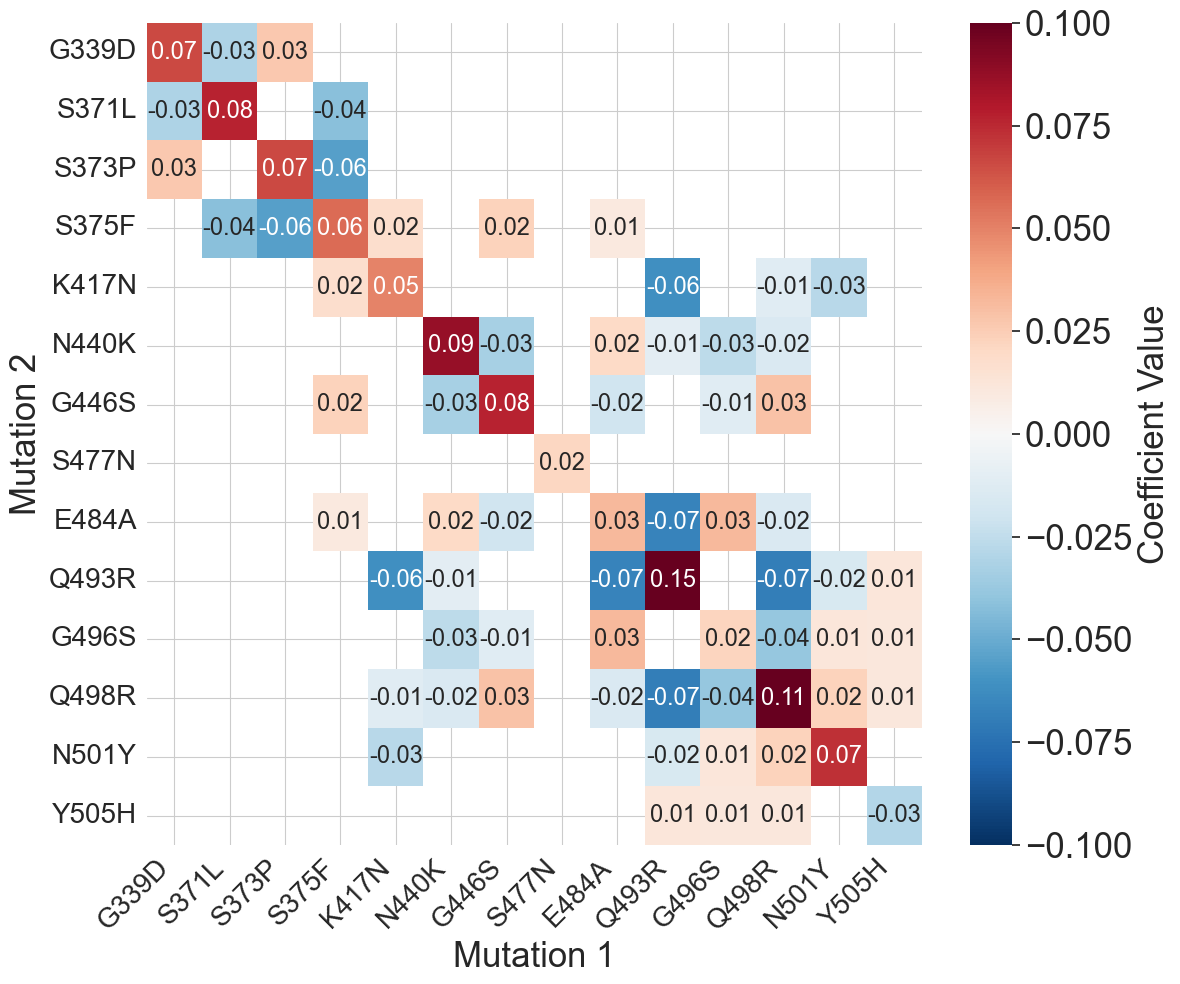

In [14]:

coeff_l=regr_2nd.coef_
mat=epi_to_matrix(coeff_l)

#truncate by removing index 8 in mutation names and in the matrix
mutation_names_trunc=mutation_names[:8]+mutation_names[9:]
mat_trunc=np.delete(mat,8,0)
mat_trunc=np.delete(mat_trunc,8,1)

# Remove zero coefficients
mat_trunc = np.where(np.abs(mat_trunc)<0.01, 0, mat_trunc)

# Create a mask for zero values to avoid displaying them in the heatmap
mask = np.abs(mat_trunc) < 0.01

# Increase the figure size for better visibility
fig, ax = plt.subplots(figsize=(12, 10))

# Set up a white theme using seaborn
sns.set_theme(style="white")

# Create the heatmap, using the mask for annotations
heatmap = sns.heatmap(mat_trunc, annot=True, fmt='.2f', cmap='RdBu_r', 
                      vmin=-0.1, vmax=0.1, mask=mask, annot_kws={"size": 17})

# Rotate and align the tick labels 
plt.xticks(np.arange(14) + 0.5, mutation_names_trunc, rotation=45, ha='right', fontsize=20)
plt.yticks(np.arange(14) + 0.5, mutation_names_trunc, rotation=0, ha='right', fontsize=20)

# Set the title 
# plt.title('Epistasis Coefficients', fontsize=20, pad=20)

# Customize the color bar
cbar = heatmap.collections[0].colorbar
cbar.set_label('Coefficient Value', fontsize=25)
cbar.ax.tick_params(labelsize=25)

# Label the axes 
plt.xlabel('Mutation 1', fontsize=25)
plt.ylabel('Mutation 2', fontsize=25)

# Use a tight layout
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('log_epistasis.png', dpi=300, bbox_inches='tight')
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'log_epistasis.eps'

fig.savefig(image_name, format=image_format, dpi=1200)
# Display the plot
plt.show()


In [15]:
mat=epi_to_matrix(coeff_l)


In [16]:

actual_values = np.array(predicted_dataset['pred_f'].to_list())

# Predictions from the first-order model
predictions_first_order = regr_1st.predict(np.array(predicted_dataset['binary'].to_list()))

# Predictions from the second-order model
predictions_second_order = regr_2nd.predict(np.array(predicted_dataset['binary_epi'].to_list()))

# Calculate RSS for both models
rss_first_order = np.sum((actual_values - predictions_first_order) ** 2)
rss_second_order = np.sum((actual_values - predictions_second_order) ** 2)

# Number of observations and parameters in each model
n = len(actual_values)
p1 = 16  # Number of parameters in the first-order model
p2 = 121  # Number of parameters in the second-order model

# Calculate the F-statistic
numerator = (rss_first_order - rss_second_order) / (p2 - p1)
denominator = rss_second_order / (n - p2)
F_statistic = numerator / denominator

# Calculate the p-value
from scipy.stats import f
dfn = p2 - p1  # Degrees of freedom for the numerator
dfd = n - p2  # Degrees of freedom for the denominator
p_value = 1 - f.cdf(F_statistic, dfn, dfd)

print("F-statistic:", F_statistic)
print("p-value:", p_value)


F-statistic: 540.2511868137386
p-value: 1.1102230246251565e-16


# Distance between residues

In [17]:
def read_pdb_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    return lines


# Provide the file path to your PDB file
file_path = '../data/6m0j.pdb'

# Read the PDB file
lines = read_pdb_file(file_path)

# Define the target residue information
residue_name = 'THR'
CHAIN = 'E'
residue_number = 478

    

    # Find the index of the line with the target residue
def get_average_coordinates(lines, residue_name, residue_chain, residue_number):
    coordinates = []
    count = 0

    for line in lines:
        if line.startswith('ATOM'):
            columns = line.split()
            if (
                columns[3] == residue_name and
                columns[4] == residue_chain and
                int(columns[5]) == residue_number
            ):
                coord = [float(columns[6]), float(columns[7]), float(columns[8])]
                coordinates.append(coord)
                count += 1

    if count > 0:
        print(f'Found {count} atoms for residue {residue_name} {residue_chain} {residue_number}')
        avg_coordinates = [sum(coords) / count for coords in zip(*coordinates)]
        return avg_coordinates
    else:
        print(f'No atoms found for residue {residue_name} {residue_chain} {residue_number}')
        return None
    

# Get the average coordinates of the target residue
get_average_coordinates(lines, residue_name, CHAIN, residue_number)


Found 7 atoms for residue THR E 478


[-42.03928571428571, 51.29414285714286, 1.075285714285714]

In [18]:
def decode_mutation(mutation_code):
    amino_acids = {
        'A': 'ALA', 'B': 'ASX', 'C': 'CYS', 'D': 'ASP', 'E': 'GLU', 'F': 'PHE', 'G': 'GLY', 'H': 'HIS', 'I': 'ILE',
        'K': 'LYS', 'L': 'LEU', 'M': 'MET', 'N': 'ASN', 'P': 'PRO', 'Q': 'GLN', 'R': 'ARG', 'S': 'SER', 'T': 'THR',
        'U': 'SEC', 'V': 'VAL', 'W': 'TRP', 'X': 'XAA', 'Y': 'TYR', 'Z': 'GLX'
    }

    original_aa = amino_acids.get(mutation_code[0], 'Unknown')
    position = int(mutation_code[1:-1])
    mutated_aa = amino_acids.get(mutation_code[-1], 'Unknown')

    return original_aa, position, mutated_aa


In [19]:
coordinates_array = np.zeros((len(mutation_names), 3))
for mutation in mutation_names:
    original_aa, position, mutated_aa = decode_mutation(mutation)
    coordinates = get_average_coordinates(lines, original_aa, CHAIN, position)
    coordinates_array[mutation_names.index(mutation)] = coordinates
#remove the 8th mutation
coordinates_array_trunc=np.delete(coordinates_array,8,0)
coordinates_array_trunc

Found 4 atoms for residue GLY E 339
Found 6 atoms for residue SER E 371
Found 6 atoms for residue SER E 373
Found 6 atoms for residue SER E 375
Found 9 atoms for residue LYS E 417
Found 8 atoms for residue ASN E 440
Found 4 atoms for residue GLY E 446
Found 6 atoms for residue SER E 477
Found 7 atoms for residue THR E 478
Found 9 atoms for residue GLU E 484
Found 3 atoms for residue GLN E 493
Found 4 atoms for residue GLY E 496
Found 9 atoms for residue GLN E 498
Found 8 atoms for residue ASN E 501
Found 12 atoms for residue TYR E 505


array([[-37.5935    ,  14.21375   ,  30.79325   ],
       [-27.0935    ,   7.619     ,  26.77416667],
       [-28.22666667,   9.081     ,  22.484     ],
       [-24.7955    ,  13.98683333,  18.19683333],
       [-30.04122222,  33.51044444,   9.614     ],
       [-37.83075   ,   9.842625  ,  14.381875  ],
       [-44.76425   ,  16.24075   ,   2.59075   ],
       [-38.71116667,  52.722     ,   1.83683333],
       [-46.06633333,  39.53322222,   2.52055556],
       [-39.712     ,  30.346     ,   8.59466667],
       [-39.12925   ,  21.229     ,   5.70375   ],
       [-39.246     ,  16.30433333,   3.837     ],
       [-34.256875  ,  15.66525   ,   3.882375  ],
       [-31.04033333,  20.53841667,   4.53208333]])

In [20]:
#compute the distance matrix
from scipy.spatial import distance_matrix
dist_matrix_trunc = distance_matrix(coordinates_array_trunc, coordinates_array_trunc)

In [21]:
#create mattrix of cross names of mutations
cross_names_matrix=np.zeros((14,14),dtype='object')
for i in mutation_names_trunc:
    for j in mutation_names_trunc:
        cross_names_matrix[mutation_names_trunc.index(i),mutation_names_trunc.index(j)]=i+'-'+j

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


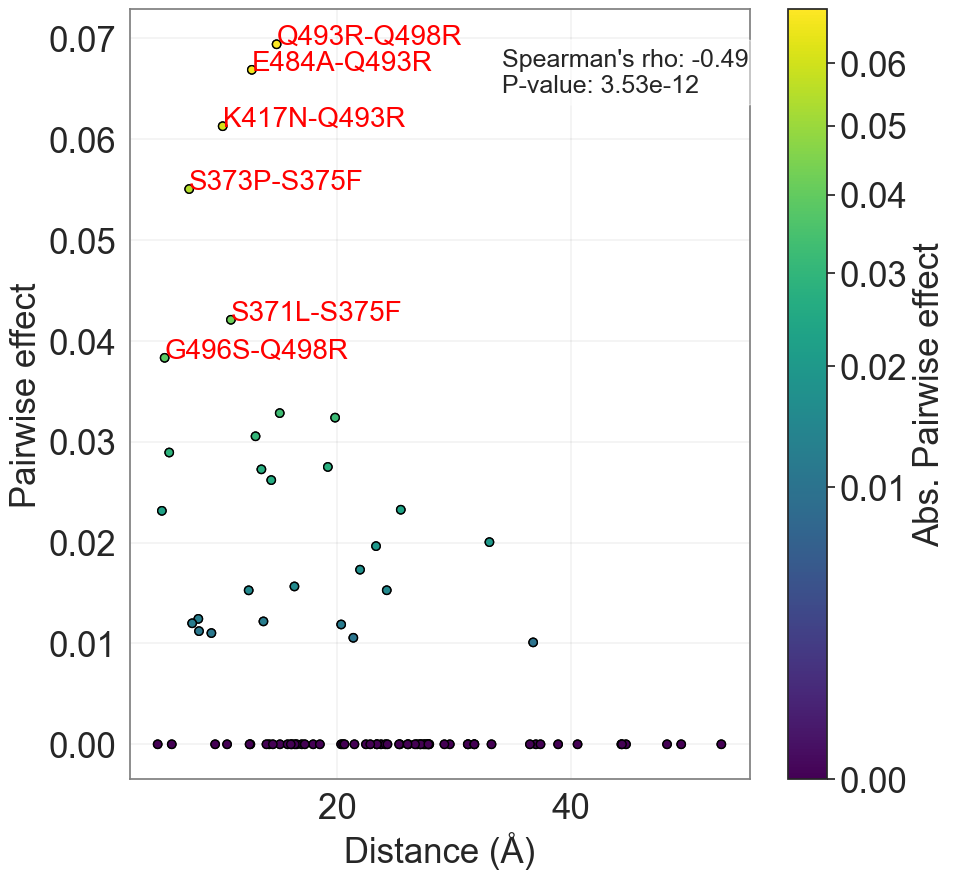

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

sns.set_theme(style="white")

# keep index where the distance is not 0
nonzero_indices = dist_matrix_trunc != 0

# Prepare data
dist_values = dist_matrix_trunc[nonzero_indices]
epi_values = abs(mat_trunc[nonzero_indices])

# Compute Pearson correlation coefficient
corr, _ = pearsonr(dist_values, epi_values)
corr_text = f'Pearson r: {corr:.2f}'

# Compute Spearman's rank correlation coefficient
spearman_corr, spearman_p = spearmanr(dist_values, epi_values)
spearman_text = f"Spearman's rho: {spearman_corr:.2f}\nP-value: {spearman_p:.2e}"

# plot the values inside the distance matrix vs the absolute values inside the epistasis matrix
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sc = ax.scatter(dist_values, epi_values,
                c=epi_values, cmap='viridis', norm=mcolors.PowerNorm(gamma=0.5), edgecolor='black')

# annotate points with high epistasis coefficient
for i in range(14):
    for j in range(i, 14):
        if dist_matrix_trunc[i, j] != 0 and abs(mat_trunc[i, j]) > 0.037:
            ax.annotate(cross_names_matrix[i, j], (dist_matrix_trunc[i, j], abs(mat_trunc[i, j])), fontsize=20, color='red')

# add colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Abs. Pairwise effect', size=25)
cbar.ax.tick_params(labelsize=25)

# Set labels, title and grid
ax.set_xlabel('Distance (Å)', fontsize=25)
ax.set_ylabel('Pairwise effect', fontsize=25)
#ax.set_title('Pairwise effect vs distance', fontsize=20)
ax.text(0.6, 0.95,  spearman_text, transform=ax.transAxes, fontsize=18, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray') 
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')

# Increase tick size
ax.tick_params(axis='both', which='major', labelsize=25)

# Save the figure
plt.savefig('log_distance_vs_epistasis.png', dpi=300, bbox_inches='tight')
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'log_distance_vs_epistasis.eps'

fig.savefig(image_name, format=image_format, dpi=1200)
# Show the figure
plt.show()


In [23]:
from scipy.stats import spearmanr
spearmanr(dist_matrix_trunc[nonzero_indices], abs(mat_trunc[nonzero_indices]))


SignificanceResult(statistic=-0.48601117768668145, pvalue=3.527510016601102e-12)